In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score as aps
from sklearn.metrics import roc_auc_score as auc

import lightgbm as lgb

from  scipy.stats import beta

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
feature_list = list(df.columns)
feature_list.remove('ID_code')
feature_list.remove('target')

X = df[feature_list].values
y = df['target'].values

In [5]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.2)

In [6]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgbm_params = {
    'objective': 'binary',
    'is_unbalance': True,
    'num_leaves': 15,
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_val, num_boost_round=100)

[1]	valid_0's binary_logloss: 0.32467
[2]	valid_0's binary_logloss: 0.337414
[3]	valid_0's binary_logloss: 0.354018
[4]	valid_0's binary_logloss: 0.370299
[5]	valid_0's binary_logloss: 0.386621
[6]	valid_0's binary_logloss: 0.402725
[7]	valid_0's binary_logloss: 0.417864
[8]	valid_0's binary_logloss: 0.432294
[9]	valid_0's binary_logloss: 0.444955
[10]	valid_0's binary_logloss: 0.456582
[11]	valid_0's binary_logloss: 0.467495
[12]	valid_0's binary_logloss: 0.47748
[13]	valid_0's binary_logloss: 0.486795
[14]	valid_0's binary_logloss: 0.494333
[15]	valid_0's binary_logloss: 0.501814
[16]	valid_0's binary_logloss: 0.508499
[17]	valid_0's binary_logloss: 0.514777
[18]	valid_0's binary_logloss: 0.520048
[19]	valid_0's binary_logloss: 0.52471
[20]	valid_0's binary_logloss: 0.52854
[21]	valid_0's binary_logloss: 0.532078
[22]	valid_0's binary_logloss: 0.534883
[23]	valid_0's binary_logloss: 0.53722
[24]	valid_0's binary_logloss: 0.539115
[25]	valid_0's binary_logloss: 0.540098
[26]	valid_0's

In [7]:
ctr_train = np.array(y_train).mean()

In [8]:
# テストデータを予測する
def evals(X, y_true, ctr_train):
    y_pred = model.predict(X)
    y_pred_post = y_pred / (y_pred  +  (1 - ctr_train) / ctr_train  * (1 - y_pred) )
    print('logloss: %.4f' % log_loss(y_true, y_pred))
    print('logloss_post: %.4f' % log_loss(y_true, y_pred_post))
    print('auc: %.4f' % auc(y_true, y_pred))
    print('norm aps:  %.4f' % (aps(y_true, y_pred)/y_true.mean()))

In [9]:
print('-'*10)
evals(X_train, y_train, ctr_train)
print('-'*10)
evals(X_val, y_val, ctr_train)
print('-'*10)
evals(X_test, y_test, ctr_train)

----------
logloss: 0.4535
logloss_post: 0.2334
auc: 0.9106
norm aps:  6.3434
----------
logloss: 0.4721
logloss_post: 0.2507
auc: 0.8548
norm aps:  5.0950
----------
logloss: 0.4728
logloss_post: 0.2549
auc: 0.8608
norm aps:  5.0320


In [10]:
def gen_plot_points(X, y_true, num_points=100):
    y_pred = model.predict(X) 
    scores = []
    ctrs = []
    delta = 1 / num_points
    for i in range(num_points):
        mask = (y_pred >= delta * i) * (y_pred < delta * (i +1))
        if mask.sum() > 0:
            scores.append(y_pred[mask].mean())
            ctrs.append(y_true[mask].mean())
    return scores, ctrs

In [11]:
scores_train, ctrs_train  =  gen_plot_points(X_train, y_train)
scores_val, ctrs_val  =  gen_plot_points(X_val, y_val)
scores_test, ctrs_test  =  gen_plot_points(X_test, y_test)

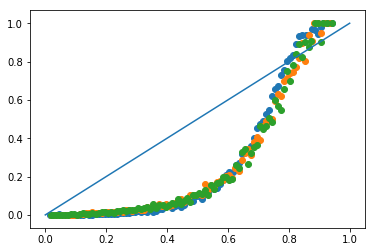

In [12]:
plt.scatter(scores_train, ctrs_train)
plt.scatter(scores_test, ctrs_test)
plt.scatter(scores_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()

In [13]:
def gen_beta_param(arr):
    mean = arr.mean()
    var = arr.var()
    alpha = mean**2 * (1-mean) / var - mean
    beta = (1-mean) / mean * alpha
    return alpha, beta

In [14]:
a_train_neg, b_train_neg = gen_beta_param(model.predict(X_train[y_train==0]))
a_train_pos, b_train_pos = gen_beta_param(model.predict(X_train[y_train==1]))

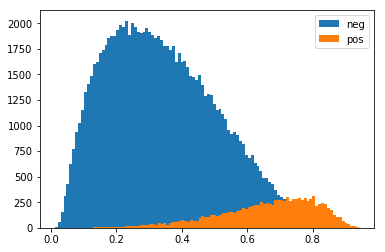

In [15]:
plt.hist(model.predict(X_train[y_train==0]) , bins=100, label='neg')
plt.hist(model.predict(X_train[y_train==1]) , bins=100, label='pos')
plt.legend()
plt.show()

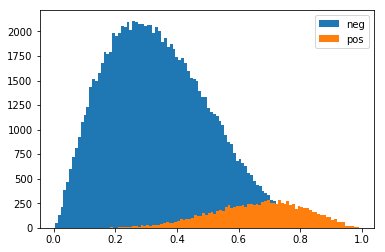

In [16]:
beta_dist_neg = np.random.beta(a_train_neg, b_train_neg, sum(y_train==0))
plt.hist(beta_dist_neg , bins=100, label='neg')
beta_dist_pos = np.random.beta(a_train_pos, b_train_pos, sum(y_train==1))
plt.hist(beta_dist_pos , bins=100, label='pos')
plt.legend()
plt.show()

In [17]:
class BetaFitting():
    def __init__(self, model, X_train, y_train):
        '''
        args:
            model:二値分類モデル、 predictで二値分類の予測値が出力される
            X_train: modelを学習したときの説明変数
            y_train: modelを学習したときの目的変数
        '''
        self.alpha_pos, self.beta_pos = self.gen_beta_param(model.predict(X_train[y_train==1]))
        self.alpha_neg, self.beta_neg = self.gen_beta_param(model.predict(X_train[y_train==0]))
        
        self.N_neg = sum(y_train == 0)
        self.N_pos = sum(y_train == 1)
        
    def gen_beta_param(self, arr):
        '''
        ベータ分布のパラメータをalpha, betaを求める。
        '''
        mean = arr.mean()
        var = arr.var()
        alpha = mean**2 * (1-mean) / var - mean
        beta = (1-mean) / mean * alpha
        return alpha, beta
        
    def fit(self, score):
        beta_pos = beta.pdf(score, self.alpha_pos, self.beta_pos)
        beta_neg = beta.pdf(score, self.alpha_neg, self.beta_neg)
        cal_score = self.N_pos * beta_pos  / (self.N_neg * beta_neg + self.N_pos * beta_pos)
        return cal_score
    
    def fit_arr(self, scores):
        cal_list = []
        for x in scores:
            cal_list.append(self.fit(x))
        
        return np.array(cal_list)

In [18]:
betaFitting = BetaFitting(model, X_train, y_train)

In [19]:
cal_scores_train = betaFitting.fit_arr(scores_train)
cal_scores_val = betaFitting.fit_arr(scores_val)
cal_scores_test = betaFitting.fit_arr(scores_test)

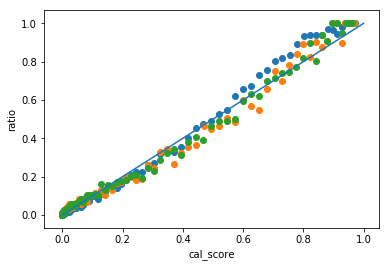

In [20]:
plt.scatter(cal_scores_train, ctrs_train)
plt.scatter(cal_scores_val, ctrs_val)
plt.scatter(cal_scores_test, ctrs_test)

plt.plot([0,1], [0,1])
plt.xlabel('cal_score')
plt.ylabel('ratio')
plt.show()

In [21]:
# テストデータを予測する
def evals2(X, y_true, ctr_train):
    y_pred = model.predict(X)
    y_pred_post = y_pred / (y_pred  +  (1 - ctr_train) / ctr_train  * (1 - y_pred) )
    cal_scores = betaFitting.fit_arr(y_pred)
    print('logloss: %.4f' % log_loss(y_true, y_pred))
    print('logloss_post: %.4f' % log_loss(y_true, y_pred_post))
    print('logloss_post_cal: %.4f' % log_loss(y_true, cal_scores))
    
    print('auc: %.4f' % auc(y_true, y_pred))
    print('auc2: %.4f' % auc(y_true, cal_scores))
    print('norm aps:  %.4f' % (aps(y_true, y_pred)/y_true.mean()))

In [22]:
print('-'*10)
evals2(X_train, y_train, ctr_train)
print('-'*10)
evals2(X_val, y_val, ctr_train)
print('-'*10)
evals2(X_test, y_test, ctr_train)

----------
logloss: 0.4535
logloss_post: 0.2334
logloss_post_cal: 0.1952
auc: 0.9106
auc2: 0.9106
norm aps:  6.3434
----------
logloss: 0.4721
logloss_post: 0.2507
logloss_post_cal: 0.2371
auc: 0.8548
auc2: 0.8548
norm aps:  5.0950
----------
logloss: 0.4728
logloss_post: 0.2549
logloss_post_cal: 0.2381
auc: 0.8608
auc2: 0.8608
norm aps:  5.0320


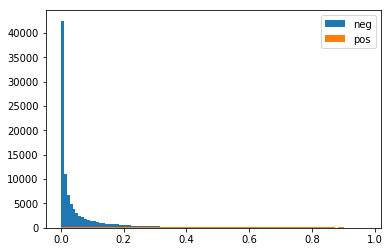

In [24]:
cal_scores_neg = betaFitting.fit_arr(model.predict(X_train[y_train==0]))
cal_scores_pos = betaFitting.fit_arr(model.predict(X_train[y_train==1]))

plt.hist(cal_scores_neg , bins=100, label='neg')
plt.hist(cal_scores_pos , bins=100, label='pos')
plt.legend()
plt.show()

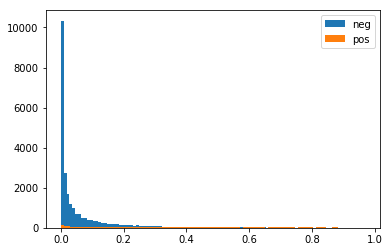

In [25]:
cal_scores_neg = betaFitting.fit_arr(model.predict(X_val[y_val==0]))
cal_scores_pos = betaFitting.fit_arr(model.predict(X_val[y_val==1]))

plt.hist(cal_scores_neg , bins=100, label='neg')
plt.hist(cal_scores_pos , bins=100, label='pos')
plt.legend()
plt.show()

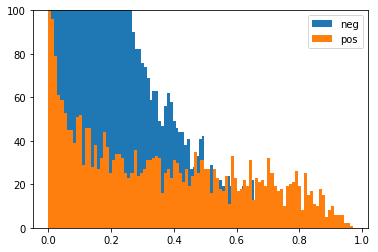

In [26]:
plt.hist(cal_scores_neg , bins=100, label='neg')
plt.hist(cal_scores_pos , bins=100, label='pos')
plt.ylim(0, 100)
plt.legend()
plt.show()

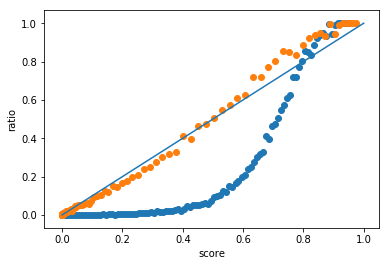

In [25]:
plt.scatter(scores_train, ctrs_train)
plt.scatter(cal_score_list, ctrs_train)

plt.plot([0,1], [0,1])
plt.xlabel('score')
plt.ylabel('ratio')
plt.show()

In [ ]:
N = 100
ratio_list = []
for i in range(N):
    x = (i+1)/N
    N_neg = sum(y_train == 0)
    N_pos = sum(y_train == 1)

    ratio = N_pos * beta.pdf(x, a_train_pos, b_train_pos)  / (N_neg * beta.pdf(x, a_train_neg, b_train_neg) + N_pos * beta.pdf(x, a_train_pos, b_train_pos) )
    ratio_list.append(ratio)

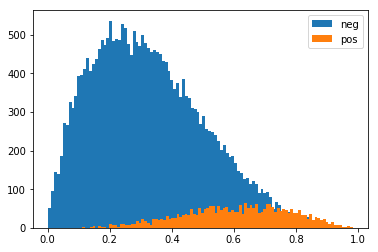

In [47]:
a_val_neg, b_val_neg = gen_beta_param(model.predict(X_val[y_val==0]))
a_val_pos, b_val_pos = gen_beta_param(model.predict(X_val[y_val==1]))

beta_dist_neg = np.random.beta(a_val_neg, b_val_neg, sum(y_val==0))
plt.hist(beta_dist_neg , bins=100, label='neg')
beta_dist_pos = np.random.beta(a_val_pos, b_val_pos, sum(y_val==1))
plt.hist(beta_dist_pos , bins=100, label='pos')
plt.legend()
plt.show()

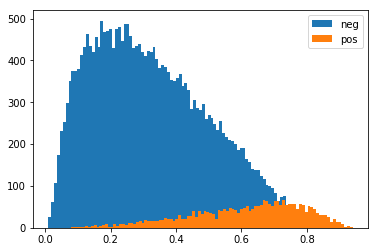

In [48]:
plt.hist(model.predict(X_val[y_val==0]) , bins=100, label='neg')
plt.hist(model.predict(X_val[y_val==1]) , bins=100, label='pos')
plt.legend()
plt.show()

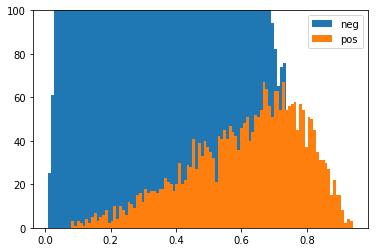

In [17]:
plt.hist(model.predict(X_val[y_val==0]) , bins=100, label='neg')
plt.hist(model.predict(X_val[y_val==1]) , bins=100, label='pos')
plt.ylim(0, 100)
plt.legend()
plt.show()

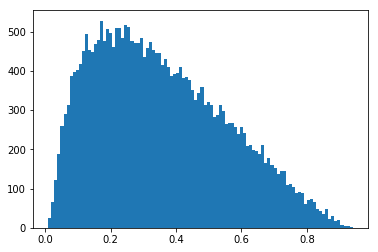

In [18]:
plt.hist(model.predict(X_val) , bins=100)
plt.show()

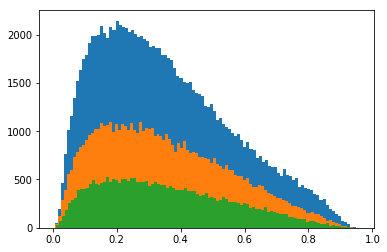

In [19]:
plt.hist(model.predict(X_train) , bins=100)
plt.hist(model.predict(X_test) , bins=100)
plt.hist(model.predict(X_val) , bins=100)
plt.show()

In [20]:
def post(scores, ctr_train):
    s_prev = np.array(scores)
    return s_prev / (s_prev  +  (1 - ctr_train) / ctr_train  * (1 - s_prev) )

In [21]:
s_post_train = post(scores_train, ctr_train)
s_post_val = post(scores_val, ctr_train)
s_post_test = post(scores_test, ctr_train)

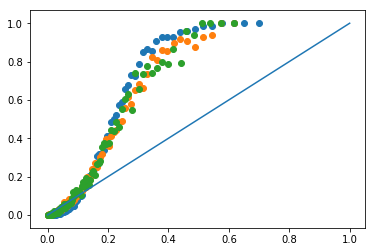

In [22]:
plt.scatter(s_post_train, ctrs_train)
plt.scatter(s_post_test, ctrs_test)
plt.scatter(s_post_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()